# CNN-TL | WITHOUT TRANSFER LEARNING
## Loading UNSW-NB15 Datasets

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import datasets, layers, models
from keras.callbacks import EarlyStopping  # Keras callbacks
from keras.layers import Dense  # Keras layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

2025-03-19 14:21:27.732774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 14:21:27.739575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 14:21:27.748155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 14:21:27.750783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 14:21:27.757347: I tensorflow/core/platform/cpu_feature_guar

# 1. UNSW-NB15-Train-Basic for training and UNSW-NB15-Test-Basic for validation


In [2]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [3]:
# Load UNSW-NB15-Test-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Test-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [4]:
# Model building and definition
with tf.device('/GPU:0'):  # Use GPU 0    
    input_shape = (24,1,1)
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(Dense(444, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Model summary
    model.summary()

I0000 00:00:1742372513.386657 2120680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742372513.386794 2120680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742372513.410421 2120680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742372513.410620 2120680 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 444)            │       682,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,214 (2.69 MB)

 Trainable params: 704,214 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Early Stopping
# Use GPU 0 explicitly for model building
with tf.device('/GPU:0'):  # Use GPU 0    
    filepath = '../models/tmp/1_Train-Basic_Test-Basic_Detection.keras' # define where the model is saved

    callbacks = [
            keras.callbacks.EarlyStopping(
                monitor = 'val_loss', # Use accuracy to monitor the model
                patience = 10 # Stop after 10 steps with lower accuracy
            ),
            keras.callbacks.ModelCheckpoint(
                filepath = filepath, # file where the checkpoint is saved
                monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
                save_best_only = True)]# Only save model if it is the best

In [6]:
with tf.device('/GPU:0'):  # Use GPU 0    
    #Configure model training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=2048, callbacks=callbacks)
    history1=history

Epoch 1/15


I0000 00:00:1742372536.904893 2123006 service.cc:146] XLA service 0x719d18003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742372536.904917 2123006 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1742372536.904920 2123006 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-19 14:22:16.925429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-19 14:22:16.983941: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-03-19 14:22:17.808892: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 2872 bytes spill stores, 2712 bytes spill loads

2025-03-19 14:22:17.898851: 

 62/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8627 - loss: 0.4569

I0000 00:00:1742372539.701194 2123006 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9201 - loss: 0.2683

2025-03-19 14:22:21.025136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_504', 56 bytes spill stores, 56 bytes spill loads



201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9238 - loss: 0.2564 - val_accuracy: 0.9918 - val_loss: 0.0343
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0318 - val_accuracy: 0.9923 - val_loss: 0.0287
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0283 - val_accuracy: 0.9924 - val_loss: 0.0279
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0275 - val_accuracy: 0.9924 - val_loss: 0.0268
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9923 - loss: 0.0264 - val_accuracy: 0.9925 - val_loss: 0.0266
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0266 - val_accuracy: 0.9926 - val_loss: 0.0254
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9923 - loss: 0.0256 - val_accuracy: 0.9924 - val_loss: 0.0258
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0259 - val_accuracy: 0.9925 - val

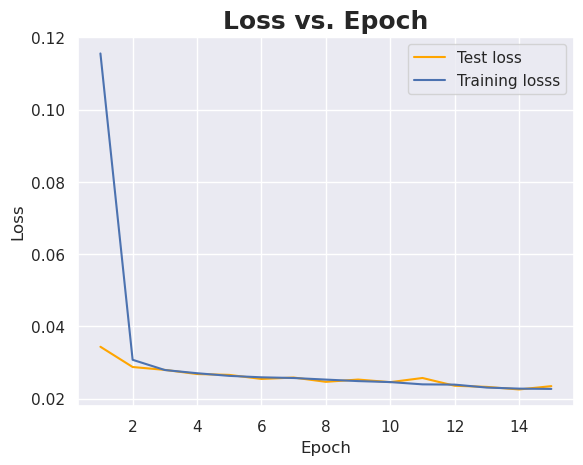

In [7]:
# summarize history for accuracy
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

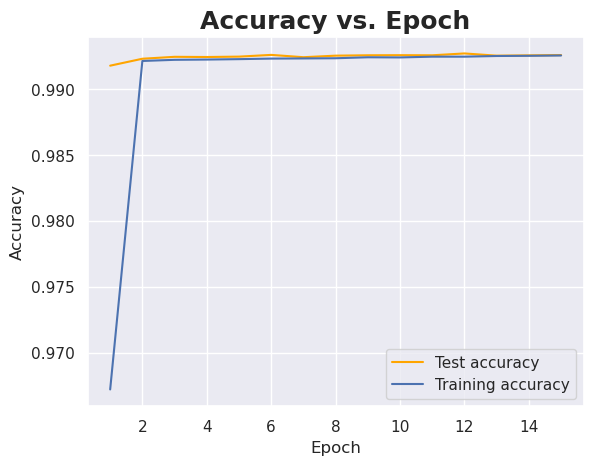

In [8]:
# summarize history for loss
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

4279/4279 ━━━━━━━━━━━━━━━━━━━━ 3s 497us/step


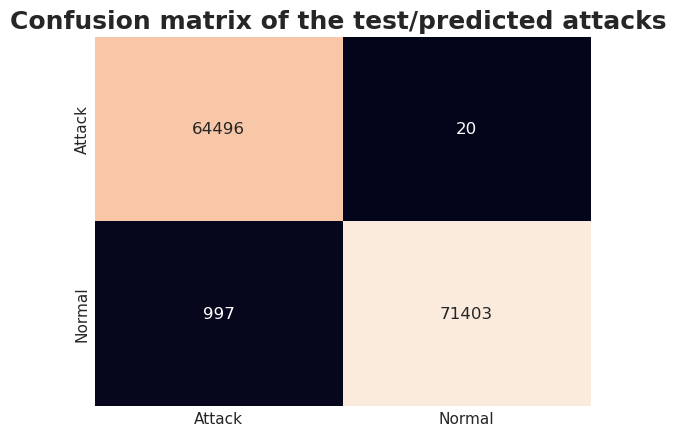

In [9]:
with tf.device('/GPU:0'):  # Use GPU 0    
    
    # Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1) 
    y_test=y_test.to_numpy()
    y_check = np.argmax(y_test, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

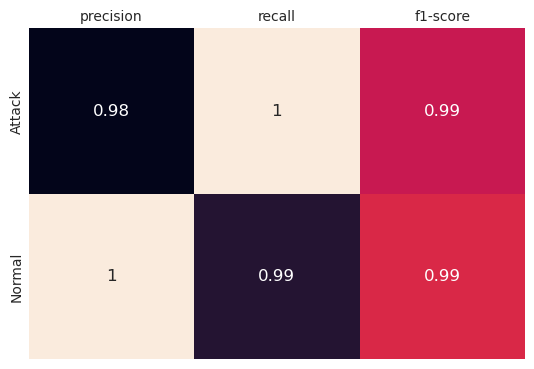

In [10]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()

In [11]:
# Showing more detailed view of Precision, Recall & F1-Score
class_rep

{'Attack': {'precision': 0.9847769990686027,
  'recall': 0.9996899993799988,
  'f1-score': 0.9921774646370636,
  'support': 64516.0},
 'Normal': {'precision': 0.9997199781582964,
  'recall': 0.9862292817679558,
  'f1-score': 0.9929288083269018,
  'support': 72400.0},
 'accuracy': 0.9925720879955593,
 'macro avg': {'precision': 0.9922484886134495,
  'recall': 0.9929596405739773,
  'f1-score': 0.9925531364819826,
  'support': 136916.0},
 'weighted avg': {'precision': 0.9926787175390068,
  'recall': 0.9925720879955593,
  'f1-score': 0.9925747687004621,
  'support': 136916.0}}

## Analysing Attack Detection

### Code

In [12]:
predicted

array([[9.9922419e-01, 7.7581347e-04],
       [9.9986494e-01, 1.3504195e-04],
       [9.9922585e-01, 7.7414408e-04],
       ...,
       [1.8527556e-12, 1.0000000e+00],
       [9.9986470e-01, 1.3532529e-04],
       [7.1817965e-08, 9.9999988e-01]], dtype=float32)

In [13]:
df = pd.DataFrame(predicted)
df.index = data.index

In [14]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [15]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [16]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [17]:
data['attack_cat'].value_counts()

attack_cat
normal            72400
generic           53677
exploits           6948
reconnaissance     2942
dos                 949
Name: count, dtype: int64

In [18]:
normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [19]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [20]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [21]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.38 % of NO detected and 98.62 % of detected samples


In [22]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.01 % of NO detected and 99.99 % of detected samples


In [23]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.14 % of NO detected and 99.86 % of detected samples


In [24]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [25]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.21 % of NO detected and 99.79 % of detected samples


In [26]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [27]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [28]:
data_plot=dff[['category', 'category_pred']]

In [29]:
data_plot

,category,category_pred
0,generic,Detected
1,generic,Detected
2,generic,Detected
4,normal,Detected
5,normal,Detected
...,...,...
145168,normal,Detected
145169,generic,Detected
145170,normal,Detected
145171,generic,Detected


### Results

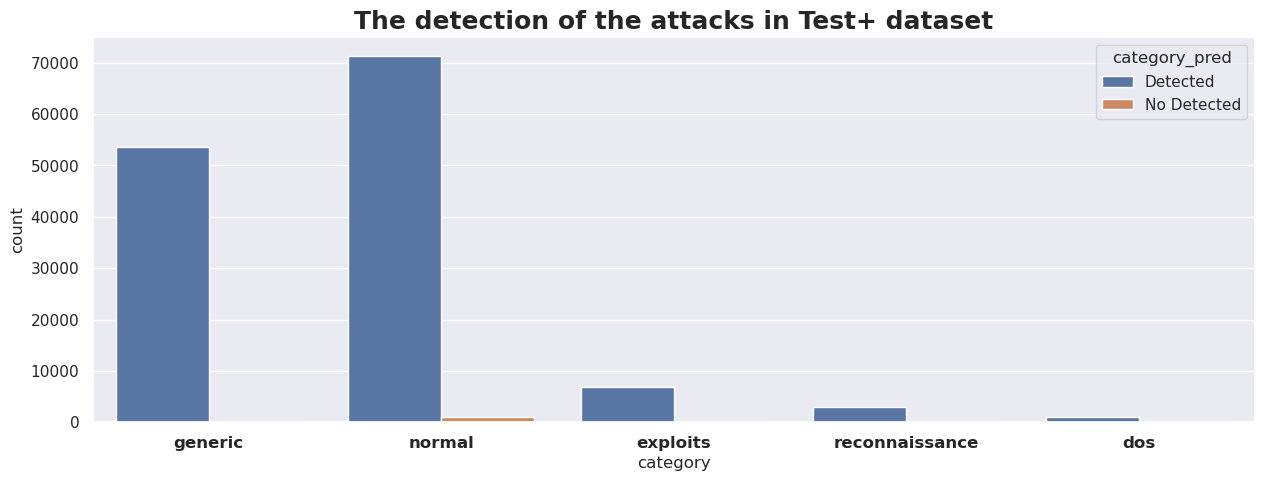

In [30]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [31]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.622928,1.377072,71403,997
1,Generic,99.988822,0.011178,53671,6
2,Exploits,99.856074,0.143926,6938,10
3,Reconnaissance,99.932019,0.067981,2940,2
4,DoS,99.789252,0.210748,947,2


# 2. UNSW-NB15-Train-Basic for training and UNSW-NB15-Test+ for validation

In [43]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [44]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test+.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 4 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [45]:
# Model building and definition
with tf.device('/GPU:0'):  # Use GPU 0    
    input_shape = (24,1,1)
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(Dense(444, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Model summary
    model.summary()

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 444)            │       682,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,214 (2.69 MB)

 Trainable params: 704,214 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Early Stopping
filepath = '../models/tmp/2_Train-Basic_Test+_Detection.keras' # define where the model is saved

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 15 # Stop after 15 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [47]:
#Configure model training
with tf.device('/GPU:0'):  # Use GPU 0    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=2048, callbacks=callbacks)
    history2=history

Epoch 1/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9232 - loss: 0.2600 - val_accuracy: 0.9858 - val_loss: 0.0600
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0321 - val_accuracy: 0.9824 - val_loss: 0.0991
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0284 - val_accuracy: 0.9672 - val_loss: 0.1315
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9923 - loss: 0.0271 - val_accuracy: 0.9615 - val_loss: 0.1346
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9924 - loss: 0.0266 - val_accuracy: 0.8858 - val_loss: 0.2185
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9926 - loss: 0.0256 - val_accuracy: 0.8107 - val_loss: 0.3510
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0268 - val_accuracy: 0.8717 - val_loss: 0.2363
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0261 - val_accuracy: 0

In [48]:
model.save('../models/UNSW-NB15_NON-TF.keras')

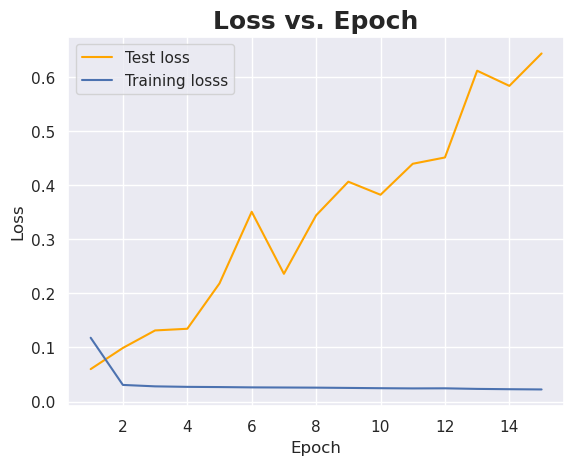

In [49]:
# summarize history for accuracy
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

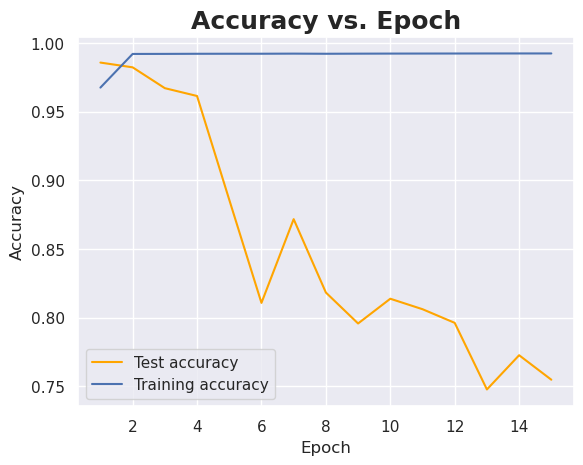

In [50]:
# summarize history for loss
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step


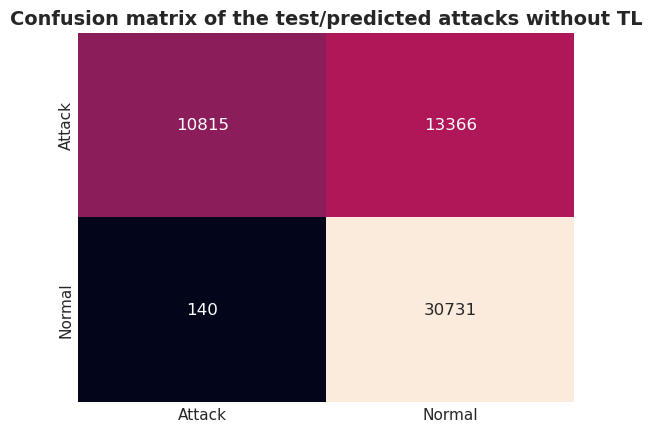

In [51]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1) 
    y_test=y_test.to_numpy()
    y_check = np.argmax(y_test, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks without TL', weight='bold', fontsize=14)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

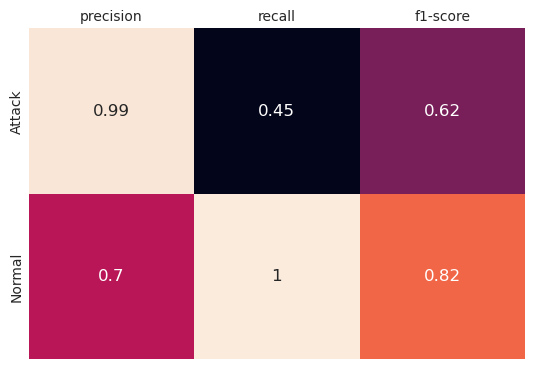

In [52]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()

In [53]:
class_rep

{'Attack': {'precision': 0.987220447284345,
  'recall': 0.447251974690873,
  'f1-score': 0.6156079234972678,
  'support': 24181.0},
 'Normal': {'precision': 0.6968954804181691,
  'recall': 0.995464999514107,
  'f1-score': 0.8198431330701099,
  'support': 30871.0},
 'accuracy': 0.7546683135944198,
 'macro avg': {'precision': 0.8420579638512571,
  'recall': 0.7213584871024901,
  'f1-score': 0.7177255282836889,
  'support': 55052.0},
 'weighted avg': {'precision': 0.8244176053871257,
  'recall': 0.7546683135944198,
  'f1-score': 0.7301350097924652,
  'support': 55052.0}}

## Analysing Attack Detection

### Code

In [54]:
predicted

array([[4.2233366e-01, 5.7766634e-01],
       [2.7523419e-01, 7.2476584e-01],
       [3.3197358e-01, 6.6802639e-01],
       ...,
       [5.1072694e-15, 1.0000000e+00],
       [7.1296448e-20, 1.0000000e+00],
       [6.4452247e-13, 1.0000000e+00]], dtype=float32)

In [55]:
df = pd.DataFrame(predicted)
df.index = data.index

In [56]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [57]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [58]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [59]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [60]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']


In [61]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [62]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 0.45 % of NO detected and 99.55 % of detected samples


In [63]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 63.02 % of NO detected and 36.98 % of detected samples


In [64]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 67.79 % of NO detected and 32.21 % of detected samples


In [65]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 57.03 % of NO detected and 42.97 % of detected samples


In [66]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 27.20 % of NO detected and 72.80 % of detected samples


In [67]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 28.74 % of NO detected and 71.26 % of detected samples


In [68]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0]})

In [69]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [70]:
data_plot=dff[['category', 'category_pred']]

In [71]:
data_plot

,category,category_pred
4,fuzzers,No Detected
5,fuzzers,No Detected
6,fuzzers,No Detected
7,fuzzers,Detected
8,fuzzers,No Detected
...,...,...
61869,normal,Detected
61870,normal,Detected
61871,normal,Detected
61872,normal,Detected


### Results

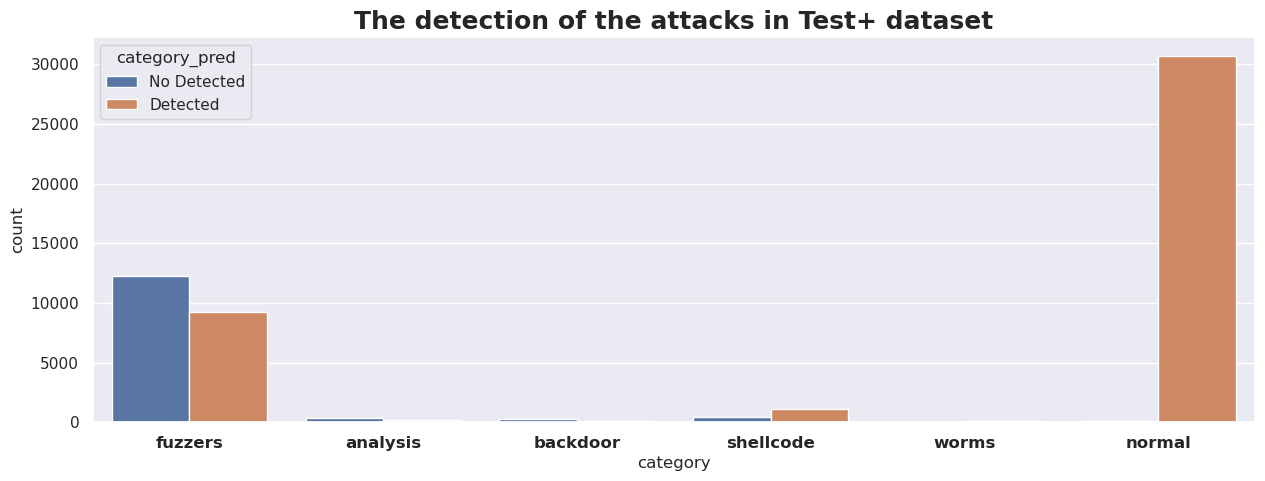

In [72]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [73]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,99.546500,0.453500,30731,140
1,Analysis,36.977492,63.022508,230,392
2,Backdoor,32.212885,67.787115,115,242
3,Fuzzers,42.970674,57.029326,9246,12271
4,Shellcode,72.799471,27.200529,1100,411
5,Worms,71.264368,28.735632,124,50


In [74]:
summary.to_csv('../others/No_TransferLearning.csv', index=False)

## Comparision between Basic-Test and Test+

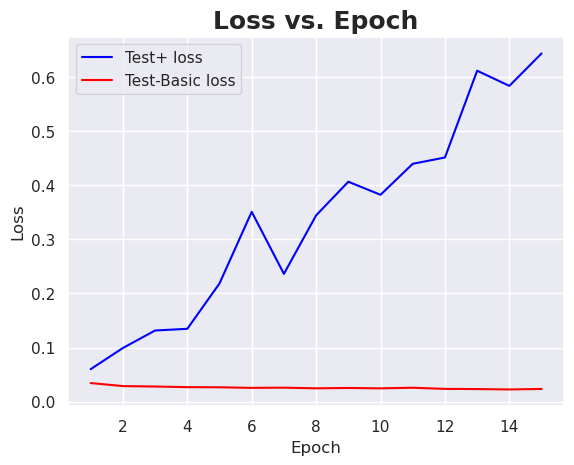

In [75]:
# summarize history for accuracy
loss_1 = history1.history['val_loss']
loss_2 = history2.history['val_loss']
x = list(range(1, len(loss_1) + 1))
plt.plot(x, loss_2, color = 'blue', label = 'Test+ loss')
plt.plot(x, loss_1, color = 'red', label = 'Test-Basic loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

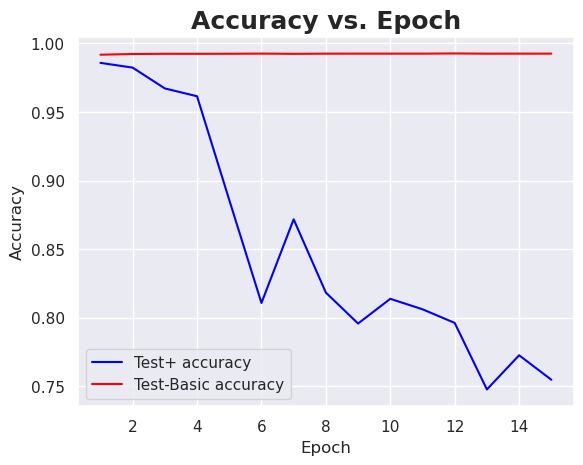

In [76]:
# summarize history for loss
acc_1 = history1.history['val_accuracy']
acc_2 = history2.history['val_accuracy']
x = list(range(1, len(acc_1) + 1))
plt.plot(x, acc_2, color = 'blue', label = 'Test+ accuracy')
plt.plot(x, acc_1, color = 'red', label = 'Test-Basic accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

# 3. UNSW-NB15-Train-Basic for training and UNSW-NB15 for validation

In [77]:
# Load UNSW-NB15
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [78]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [79]:
x_test.shape

(602516, 24, 1, 1)

In [113]:
# Load Transfer Learning model
modelFE = load_model('../models/UNSW-NB15_NON-TF.keras')

In [114]:
#Evaluate the model
results = model.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.04142189398407936, 0.9867505431175232]


18829/18829 ━━━━━━━━━━━━━━━━━━━━ 7s 370us/step


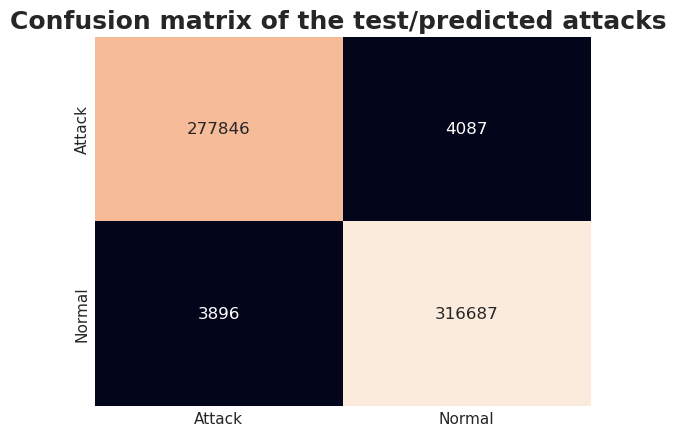

In [115]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = model.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

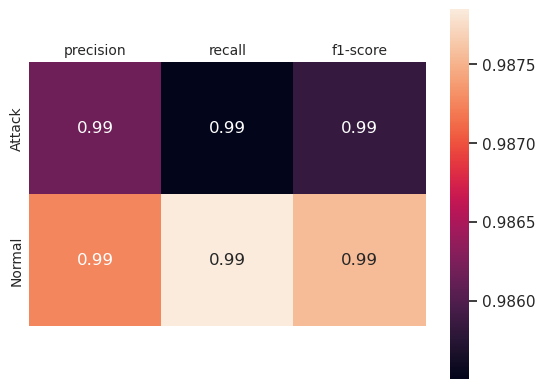

In [116]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [117]:
from sklearn import metrics



In [118]:
# Precision, Recall & F1-Score
FPR, TPR, THRESHOLD = metrics.roc_curve(y_check, y_class)

In [119]:
FPR[1]

0.014496351970148936

In [120]:
class_rep

{'Attack': {'precision': 0.9861717457816016,
  'recall': 0.985503648029851,
  'f1-score': 0.9858375837140196,
  'support': 281933.0},
 'Normal': {'precision': 0.9872589424329902,
  'recall': 0.9878471409900088,
  'f1-score': 0.9875529541269527,
  'support': 320583.0},
 'accuracy': 0.9867505593212462,
 'macro avg': {'precision': 0.9867153441072959,
  'recall': 0.9866753945099299,
  'f1-score': 0.9866952689204862,
  'support': 602516.0},
 'weighted avg': {'precision': 0.9867502146755266,
  'recall': 0.9867505593212462,
  'f1-score': 0.9867502874315796,
  'support': 602516.0}}

## Analysing Attack Detection

### Code

In [121]:
predicted

array([[9.9937719e-01, 6.2289066e-04],
       [9.9942160e-01, 5.7839457e-04],
       [7.1963847e-01, 2.8036150e-01],
       ...,
       [3.8130571e-07, 9.9999964e-01],
       [2.7143637e-16, 1.0000000e+00],
       [2.6751757e-14, 1.0000000e+00]], dtype=float32)

In [123]:
df = pd.DataFrame(predicted)
df.index = data.index

In [124]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [125]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [126]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [127]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [128]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [129]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [130]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.22 % of NO detected and 98.78 % of detected samples


In [131]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 1.29 % of NO detected and 98.71 % of detected samples


In [132]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 8.68 % of NO detected and 91.32 % of detected samples


In [133]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 16.62 % of NO detected and 83.38 % of detected samples


In [134]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.20 % of NO detected and 99.80 % of detected samples


In [135]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 4.02 % of NO detected and 95.98 % of detected samples


In [136]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.06 % of NO detected and 99.94 % of detected samples


In [137]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.81 % of NO detected and 99.19 % of detected samples


In [138]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.19 % of NO detected and 99.81 % of detected samples


In [139]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 2.30 % of NO detected and 97.70 % of detected samples


In [140]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [141]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [142]:
data_plot=dff[['category', 'category_pred']]

In [143]:
data_plot

,category,category_pred
0,exploits,Detected
1,exploits,Detected
2,reconnaissance,Detected
3,exploits,Detected
4,exploits,Detected
...,...,...
642561,normal,Detected
642562,normal,Detected
642563,normal,Detected
642564,normal,Detected


### Results

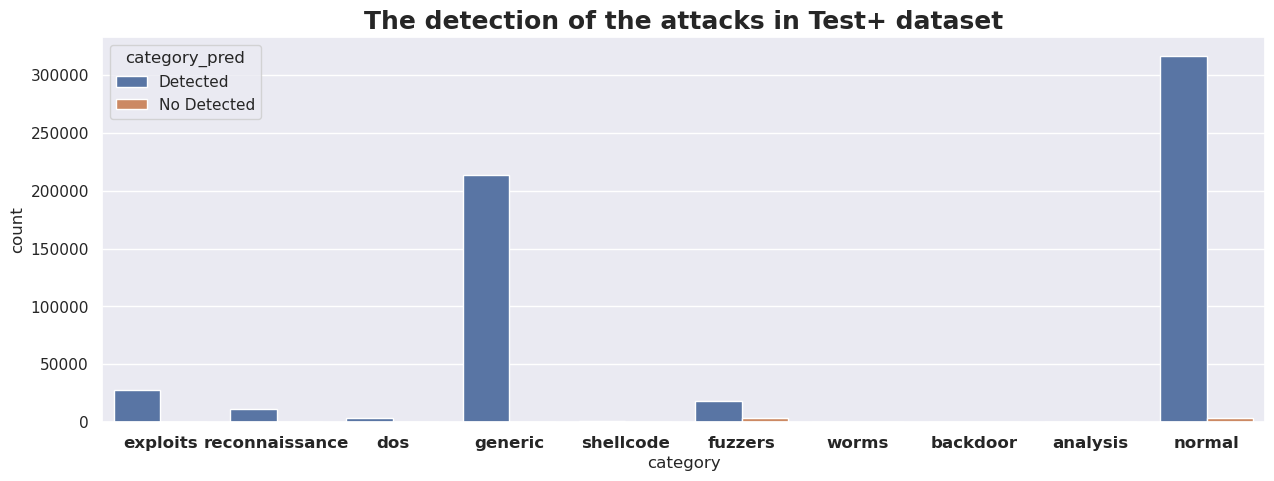

In [144]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [145]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.784714,1.215286,316687,3896
1,Analysis,98.713826,1.286174,614,8
2,Backdoor,91.316527,8.683473,326,31
3,Fuzzers,83.380583,16.619417,17941,3576
4,Shellcode,99.801456,0.198544,1508,3
5,Worms,95.977011,4.022989,167,7
6,Generic,99.943851,0.056149,213598,120
7,Exploits,99.187767,0.812233,28087,230
8,Reconnaissance,99.805973,0.194027,11831,23
9,DoS,97.696091,2.303909,3774,89


In [146]:
summary.to_csv('../others/No_TransferLearningFull.csv', index=False)